# Analizando datos del cluster de Univalle

En este *notebook* se mostrarán las instrucciones que permitirán analizar los datos del cluster de Univalle.

El código abajo lee datos el archivo `history.csv`. 

In [1]:
import pandas as pd

CSVFILENAME = 'history-2019-09-09.csv.gz'

df = pd.read_csv(CSVFILENAME,compression="gzip",dtype='unicode')

Se usa como índice del análisis el campo `JobCurrentStartDate`.

In [2]:
INDEXFIELD = 'JobCurrentStartDate'

df[INDEXFIELD] = pd.to_datetime(df[INDEXFIELD], unit='s')
df = df.set_index(INDEXFIELD)

A continuación se definen unas funciones auxiliares que permitirán visualizar los datos.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math

def analizarRangoAnos(ano1,ano2, log = True):
    values = [] # valores reales
    vallog = [] # valores logaritmicos
    xlabel = []
    contador = 1
    for i in range(ano1, ano2 + 1):
        for j in range(1, 13):
            fecha = '%d-%d'%(i,j)
            valT = df.loc[fecha].shape[0]
            values.append(valT)
            if valT <= 0:
                valT = 1
            if log:
                vallog.append(math.log2(valT))
            else:
                vallog.append(valT)                
            #xlabel.append(fecha)
            xlabel.append(contador)
            contador = contador + 1

    return (xlabel, vallog, values)

def analizarPorAno(ano, log = True):
    return analizarRangoAnos(ano, ano, log)

def showPlot(xlab, val):
    fit = plt.figure()
    plt.plot(xlab,val)
    plt.grid()
    plt.show()

Si usted desear revisar el de un año se ejecuta el siguiente código

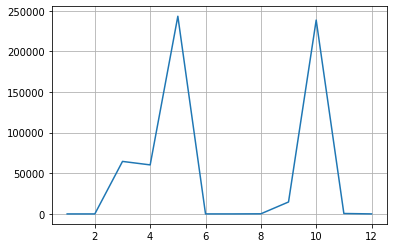

[9, 4, 64598, 60325, 243224, 23, 25, 140, 14697, 238516, 523, 23]

In [5]:
(xlab, vallog, realvalues) = analizarPorAno(2018, False)
showPlot(xlab, vallog)
realvalues

Si usted desea revisar el rango de años del 2015 al 2019 se debe ejecutar el siguiente código.

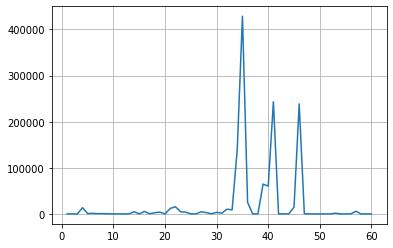

[0,
 0,
 0,
 13603,
 798,
 1208,
 532,
 753,
 205,
 98,
 15,
 36,
 55,
 4745,
 98,
 5436,
 372,
 2594,
 3895,
 5,
 11753,
 15758,
 4792,
 3793,
 184,
 1,
 4717,
 2707,
 296,
 3394,
 1692,
 10218,
 8892,
 141064,
 428534,
 24833,
 9,
 4,
 64598,
 60325,
 243224,
 23,
 25,
 140,
 14697,
 238516,
 523,
 23,
 22,
 41,
 23,
 23,
 1546,
 34,
 61,
 103,
 5736,
 0,
 0,
 0]

In [6]:
(xlab, vallog, realvalues) = analizarRangoAnos(2015, 2019, False)
showPlot(xlab, vallog)

En la ejecución anterior se inicializó una variable llamada 'realvalues'.
Esta variable contiene las tareas que se ejecutaron por meses.

In [14]:
realvalues

[0,
 0,
 0,
 13603,
 798,
 1208,
 532,
 753,
 205,
 98,
 15,
 36,
 55,
 4745,
 98,
 5436,
 372,
 2594,
 3895,
 5,
 11753,
 15758,
 4792,
 3793,
 184,
 1,
 4717,
 2707,
 296,
 3394,
 1692,
 10218,
 8892,
 141064,
 428534,
 24833,
 9,
 4,
 64598,
 60325,
 243224,
 23,
 25,
 140,
 14697,
 238516,
 523,
 23,
 22,
 41,
 23,
 23,
 1546,
 34,
 61,
 103,
 5736,
 0,
 0,
 0]

Vamos a identificar los usuarios y cuantas tareas han enviado a ejecutar en el cluster.

In [98]:
group = df.groupby('User', as_index = False).count()
group = group[['User','ClusterId']]
group.columns = ['User', 'Total jobs']
group.sort_values(by='Total jobs')

,User,Total jobs
69,test1@cloud.univalle.edu.co,1
5,c-dorado@cloud.univalle.edu.co,1
17,e-sd-01@cloud.univalle.edu.co,1
37,r-jsvinasco@cloud.univalle.edu.co,2
27,ma0@cloud.univalle.edu.co,2
...,...,...
20,edza@cloud.univalle.edu.co,21358
31,nmossos@cloud.univalle.edu.co,21516
12,clouduser@cloud.univalle.edu.co,23778
28,ma@cloud.univalle.edu.co,113279
